In [6]:
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.datasets import make_moons, make_circles

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint


In [2]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, A)


In [3]:
def get_batch(y, t, batch_time=8, batch_size=256):
    size = len(t)
    start = np.random.randint(size-batch_time, size=batch_size)
    y0 = y[start]
    t0 = np.random.randint(size-batch_time)
    ts = t[t0:t0+batch_time]
    ys = torch.stack([y[start + i] for i in range(batch_time)], dim=0)
    return y0, ts, ys


In [4]:
class ODEF(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Linear(2, 2, bias=False)
        nn.init.normal_(self.net.weight)

    def forward(self, t, y):
        return self.net(y)


In [5]:
def plot(func, y, y0, t, epoch: int = None):
    y_pred = odeint(func, y0, t, method='rk4')[:, 0]

    plt.figure(figsize=(12, 3))

    ax = plt.subplot(1, 3, 1)
    ax.set_title('Фазовый портрет')
    ax.plot(y_pred.detach()[:, 0].cpu(), y_pred.detach()[:, 1].cpu(), c='r')
    ax.scatter(y.detach()[:, 0].cpu(), y.detach()[:, 1].cpu(), s=1, c='k', alpha=0.7)
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')

    ax = plt.subplot(1, 3, 2)
    ax.set_title('Траектории')
    ax.plot(t.cpu(), y_pred.detach()[:, 0].cpu())
    ax.plot(t.cpu(), y_pred.detach()[:, 1].cpu())
    ax.scatter(t.cpu(), y.detach()[:, 0].cpu(), s=1, alpha=0.7)
    ax.scatter(t.cpu(), y.detach()[:, 1].cpu(), s=1, alpha=0.7)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y_1$, $y_2$')
    ax.set_xlim(t.cpu().min(), t.cpu().max())
    ax.set_ylim(-1, 1)

    ax = plt.subplot(1, 3, 3)
    Y, X = np.mgrid[-1:1:21j, -1:1:21j]
    dydt = func(0, torch.Tensor(np.stack([X, Y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax.set_title('Векторное поле обучения')
    ax.streamplot(X, Y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

    plt.tight_layout()
    if epoch is None:
        plt.show();
    else:
        plt.savefig('imgs/{:04d}'.format(epoch));
        plt.clf();
        plt.close();


In [6]:
Path('imgs').mkdir(exist_ok=True)

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y0 = torch.Tensor([[0.6, 0.3]]).to(device)
t = torch.linspace(0., 20., 200).to(device)
A = torch.Tensor([[-0.1, -1.], [1., -0.1]]).to(device)

y = odeint(Lambda(), y0, t, method='rk4')[:, 0]
y = y + 0.01 * torch.randn(y.size(), device=device)

epoches = 500
func = ODEF().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

pbar = tqdm(total=epoches)

with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        y0, ts, ys = get_batch(y, t)
        y_pred = odeint(func, y0, ts, method='rk4').to(device)
        loss = torch.mean(torch.abs(y_pred - ys))
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))

        with torch.no_grad():
            if (i % 20) == 0:
                y0 = torch.Tensor([[0.6, 0.3]]).to(device)
                plot(func, y, y0, t, i);

    with torch.no_grad():
        y0 = torch.Tensor([[0.6, 0.3]]).to(device)
        plot(func, y, y0, t, epoches);

images = []
filenames = sorted(list(Path('imgs/').glob('*.png')))
for filename in filenames:
    images.append(imageio.imread(str(filename)))
imageio.mimsave('simple_ode.gif', images, duration=5, format='GIF')
shutil.rmtree('imgs')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


![alt](simple_ode.gif)

In [7]:
def plot_flow(func, num_samples: int = 30_000, num_timestemps: int = 20, name: str = 'cnf_ode'):
    Path('imgs').mkdir(exist_ok=True)

    timesteps = torch.linspace(t0, t1, num_timestemps, device=device)
    target_sample, _ = get_batch(num_samples)

    z_t0 = p_z0.sample([num_samples]).to(device)
    logp_diff_t0 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    z_t_samples, _ = odeint(
        func,
        (z_t0, logp_diff_t0),
        timesteps,
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T

    z_t1 = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(device)

    z_t_density, logp_diff_t = odeint(
        func,
        (z_t1, logp_diff_t1),
        timesteps.flip(0),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    for (t, z_sample, z_density, logp_diff) in zip(timesteps, z_t_samples, z_t_density, logp_diff_t):

        logp = p_z0.log_prob(z_density) - logp_diff.view(-1)

        fig = plt.figure(figsize=(10, 3))
        plt.axis('off')
        plt.margins(0, 0)
        plt.suptitle(f'{t:.2f}s', size=15)
        plt.tight_layout()

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title('Target')
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Samples')
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Probability')
        ax3.get_xaxis().set_ticks([])
        ax3.get_yaxis().set_ticks([])

        ax1.hist2d(*target_sample.detach().cpu().T.numpy(), bins=300, density=True, range=[[-3, 3], [-3, 3]])
        ax2.hist2d(*z_sample.detach().cpu().T.numpy(), bins=300, density=True, range=[[-3, 3], [-3, 3]])
        plt.pcolormesh(*z_t1.T.view(2, 100, 100).detach().cpu(), logp.exp().view(100, 100).detach().cpu())
        plt.savefig('imgs/cnf-%.2f.png' % t)
        plt.close()

    images = []
    filenames = sorted(list(Path('imgs/').glob('*.png')))
    for filename in filenames:
        images.append(imageio.imread(str(filename)))
    imageio.mimsave(f'{name}.gif', images, duration=5, format='GIF')
    shutil.rmtree('imgs')


In [8]:
def get_batch(num_samples):
    points, _ = make_moons(n_samples=num_samples, noise=0.06)
    points = (points - points.mean(0)) / points.std(0) * 1.5
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    return(x, logp_diff_t1)


In [9]:
def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


In [10]:
class PlanarFlow(nn.Module):

    def __init__(self, inp: int, width: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, inp, bias=False)
        )

    def forward(self, z):
        return self.net(z)

class CNF(nn.Module):

    def __init__(self, inp: int, width: int):
        super().__init__()
        self.net = PlanarFlow(inp, width)

    def forward(self, t, state):
        z = state[0]
        logp_z = state[1]
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.net(z)
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(z.size(0), 1)
        return (dz_dt, dlogp_z_dt)


In [11]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoches = 1000
t0, t1 = 0, 1
func = CNF(2, 256).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[1., 0.0], [0.0, 1.]]).to(device)
    )
pbar = tqdm(total=epoches)
total_loss = []
with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        x, logp_diff_t1 = get_batch(512)
        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.linspace(t1, t0, 10).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='midpoint',
            adjoint_method='midpoint'
        )
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
        loss = -logp_x.mean(0)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))
        total_loss.append(loss.item())


In [12]:
plot_flow(func, num_timestemps=60, name='simple_cnf_ode')

![alt](simple_cnf_ode.gif)

In [13]:
class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]


In [14]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoches = 1000
t0, t1 = 0, 1
func = CNF(2, 32, 64).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[1., 0.0], [0.0, 1.]]).to(device)
    )
pbar = tqdm(total=epoches)
total_loss = []
with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        x, logp_diff_t1 = get_batch(512)
        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.tensor([t1, t0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
            adjoint_method='dopri5'
        )
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
        loss = -logp_x.mean(0)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))
        total_loss.append(loss.item())


In [15]:
plot_flow(func, num_timestemps=60)


![alt](cnf_ode.gif)

### Непрерывная диффузия

Наша цель — построить процесс диффузии $\{x(t)\}_{t=0}^T$ с непрерывным временем $t\in[0, T]$, такой, что $x(0)\sim p_0$ переходящий в $x(T)\sim p_T$. Здась $p_0$ — распределение исходных данных, а $p_T$ — априорное распределение (обычно нормальное). Этот процесс диффузии можно представить в виде Itô SDE
$$
dx = f(x, t)dt + g(t)dw
$$
где $dw$ — стандартный Винерский процесс (Броуновское движение), $f(\cdot, t)$ — коэффициент дрейфа функции $x(t)$, $g(t)$ — коэфициент диффузии $x(t)$.

Запишем $p_t(x)$ — распределение $x(t)$, а $p_{st}(x(t)| x(s))$ — ядро перехода от $x(s)$ к $x(t)$ при $0\leq s < t\leq T$.

### Сэмплирование 

Процесс обратной диффузии также является процессом диффузии, который протекает в обратном времени и задается СДУ вида 
$$
dx = [f(x, t) - g(t)^2 \nabla_x\log{p_t(x)}]dt +g(t)d\bar w
$$
где $d\bar w$ — Винерский обратный процесс (от $T$ до $0$), а $dt$ — отрицательное прирощение по времени. Это выражение мы в дальнейшем используем для генерации объектов из распределения $p_0$.

### Обучение модели

Для обучения будем использовать следующую задачу минимизации
$$
\theta^* = \operatorname*{argmin}_\theta\mathbb{E}_t\{\lambda(t)\mathbb{E}_{x(0)}\mathbb{E}_{x(T)|x(0)}[||s_\theta(x, t)-\nabla_{x(t)}\log{p_{0t}(x(t)|x(0))}||_2^2]\}
$$
здесь $\lambda(t): [0, T]\to\mathbb{R}^+$, выбираем его пропорционально $\lambda(t) \propto 1/\mathbb{E}[||\nabla_{x(t)}\log{p_{0t}(x(t)|x(0))}||_2^2]$.

### DDPM в SDE

Как мы помним, DDPM переходы по марковской цепи для диффузии используется 
$$
x_i = \sqrt{1-\beta_i}x_{i-1} + \sqrt{\beta_i}z_{i-1}
$$
где $i=1,2,\dots,N$. При $N\to\infty$ получим, что
$$
dx = -\dfrac{1}{2}\beta(t)xdt + \sqrt{\beta(t)}dw
$$

Если $beta(t)$ — линейная функция $\beta(t) = \beta(0) + t\cdot(\beta(T) - \beta(0))$. Тогда интеграл
$$
\int\limits_0^t \beta(s)ds = \int\limits_0^t [\beta(0) + s\cdot(\beta(T) - \beta(0))]ds = \beta(0)\cdot t + (\beta(T) - \beta(0))\cdot\dfrac{t^2}{2}
$$
Тогда можно записать ядро перехода как
$$
p_{0t}(x(t)|x(0)) = \mathcal{N}(x(t); x(0)e^{-1/2\int_0^t\beta(s)ds}, I-Ie^{\int_0^t\beta(s)ds}) = \\
= \mathcal{N}(x(t); x(0)e^{-1/2\int_0^t\beta(s)ds}, (1-e^{\int_0^t\beta(s)ds})I)
$$

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Resize, Compose, Normalize
from torchvision.utils import make_grid


In [41]:
alpha=0.95

def dequantize(x, nvals=256):
        """[0, 1] -> [0, nvals] -> add uniform noise -> [0, 1]"""
        noise = x.new().resize_as_(x).uniform_()
        x = x * (nvals - 1) + noise
        x = x / nvals
        return x

transform = Compose([
    Resize(16),                 # Уменьшаем размер изображений
    ToTensor(),
    # Normalize([0.5], [0.5]),  # Map to (-1, 1)
    # Lambda(lambda t: 255 * t),  # Приводим распределение обратно к диапазону [0, 255]
    dequantize,
    Lambda(lambda x: alpha + (1 - 2 * alpha) * x),
    Lambda(lambda x: (x / (1 - x)).log()),
])

mnist = MNIST('../data/', download=True, transform=transform)
train, _ = torch.utils.data.random_split(mnist, [10000, 50000])
train = DataLoader(train, batch_size=64, shuffle=True, drop_last=True)


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample = next(iter(train))[0].to(device)


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsde

batch_size, state_size, brownian_size = 256, 256, 2
t_size = 10

ts = torch.linspace(0, 1, t_size).to(device)

In [89]:
def fill_tail_dims(y: torch.Tensor, y_like: torch.Tensor):
        """Fill in missing trailing dimensions for y according to y_like."""
        return y[(...,) + (None,) * (y_like.dim() - y.dim())]

class ScoreMatchingSDE(nn.Module):

    def __init__(
        self,
        denoiser: nn.Module,
        input_size=(1,16,16),
        beta_min=0.1,
        beta_max=20,
        partitions=1
    ):
        super().__init__()

        self.input_size = input_size
        self.denoiser = denoiser

        self.beta_min = beta_min
        self.beta_max = beta_max
        self.partitions = partitions

    def score(self, t, y):
        if isinstance(t, float):
            t = y.new_tensor(t)
        if t.dim() == 0:
            t = t.repeat(y.shape[0])
        return self.denoiser(t, y)

    def _beta(self, t):
        """linear beta(t) = k*t + b"""
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def _int_beta(self, t):
        """integrate betas in-time"""
        return t * self.beta_min + 0.5 * t ** 2 * (self.beta_max - self.beta_min)

    def analytical_mean(self, t, x0):
        """VP SDE mean"""
        return x0 * fill_tail_dims((- 0.5 * self._int_beta(t)).exp(), x0)

    def analytical_var(self, t, x0):
        """VP SDE varience"""
        return fill_tail_dims((1 - 1 / self._int_beta(t).exp()), x0)

    @torch.no_grad()
    def analytical_score(self, x_t, t, x0):
        mean = self.analytical_mean(t, x0)
        var = self.analytical_var(t, x0)
        return - (x_t - mean) / var.clamp_min(1e-5)

    @torch.no_grad()
    def analytical_sample(self, t, x0):
        mean = self.analytical_mean(t, x0)
        var = self.analytical_var(t, x0)
        return mean + torch.randn_like(mean) * var.sqrt()

    def f(self, t, y):
        return -0.5 * self._beta(t) * y

    def g(self, t, y):
        return (fill_tail_dims(self._beta(t).sqrt(), y).expand_as(y))

    def forward(self, t, x0):
        lambda_t = self.analytical_var(t, x0).flatten(start_dim=1).mean(dim=1)
        x0 = x0.repeat_interleave(self.partitions, dim=0)
        x_t = self.analytical_sample(t, x0)

        fake_score = self.score(t, x_t)
        true_score = self.analytical_score(x_t, t, x0)
        loss = (lambda_t * ((fake_score - true_score) ** 2).flatten(start_dim=1).sum(dim=1))
        return loss

In [90]:
def postprocess(x, alpha=0.95, clamp=True):
    x = (x.sigmoid() - alpha) / (1 - 2 * alpha)
    return x.clamp(min=0., max=1.) if clamp else x

In [91]:
def sample_time(x0, t0, t1, partitions=1):
    u = torch.rand(size=(x0.shape[0], partitions), dtype=x0.dtype, device=x0.device)
    u.mul_((t1 - t0) / partitions)
    shifts = torch.arange(0, partitions, device=x0.device, dtype=x0.dtype)[None, :]
    shifts.mul_((t1 - t0) / partitions).add_(t0)
    t = (u + shifts).reshape(-1)
    return t

In [98]:
from tqdm import tqdm
from unet import Unet, LinearTimeSelfAttention

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoches = 5
t0, t1 = 0, 1
denoiser = Unet(
    input_size=(1, 16, 16),
    dim_mults=(1, 2, 4,),
    attention_cls=LinearTimeSelfAttention,
)
sde_ddpm = ScoreMatchingSDE(denoiser)
optimizer = torch.optim.Adam(sde_ddpm.parameters(), lr=1e-3)
# pbar = tqdm(total=epoches)
total_loss = []
# with pbar:
for i in range(epoches):
    epoch_loss = []
    for sample, _ in tqdm(train):
        optimizer.zero_grad()
        time = sample_time(sample, t0, t1)
        loss = sde_ddpm(time, sample).mean(dim=0)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, epoch_loss[-1]))
    # pbar.update(1)
    total_loss.append(np.mean(epoch_loss))


 17%|█▋        | 27/156 [00:58<04:39,  2.17s/it]:27<?, ?it/s] 


KeyboardInterrupt: 

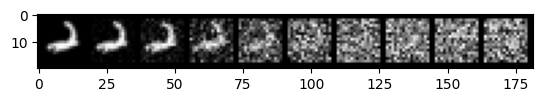

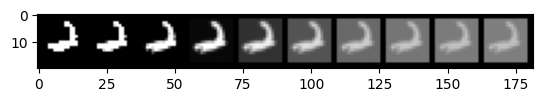

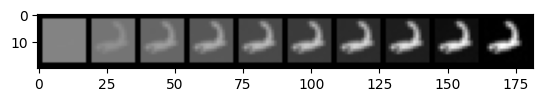

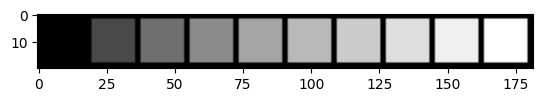

In [59]:

sde_diff = ScoreMatchingSDE(denoiser)

noised = [postprocess(sde_diff.analytical_sample(ts[i].cpu(), sample.cpu()[0])) for i in range(10)]
plt.imshow(ToPILImage()(make_grid(noised, nrow=10, normalize=True)))
plt.show()

denoised = [postprocess(sde_diff.analytical_score(noised[0], ts[i].cpu(), sample.cpu()[0])) for i in range(10)]
plt.imshow(ToPILImage()(make_grid(denoised, nrow=10, normalize=True)))
plt.show()


noised = [(sde_diff.f(ts[i].cpu(), sample.cpu()[0])) for i in range(10)]
plt.imshow(ToPILImage()(make_grid(noised, nrow=10, normalize=True)))
plt.show()

denoised = [(sde_diff.g(ts[i].cpu(), sample.cpu()[0])) for i in range(10)]
plt.imshow(ToPILImage()(make_grid(denoised, nrow=10, normalize=True)))
plt.show()

In [62]:
sde_diff(ts[1].cpu(), sample.cpu())

tensor([288.9498, 255.1563, 287.7413, 274.7783, 272.0470, 270.7300, 249.7079,
        244.0576, 280.0407, 255.9550, 230.9274, 259.0180, 271.0232, 259.4678,
        247.2188, 245.6138, 239.2370, 279.3791, 255.5644, 281.6728, 248.8304,
        256.4174, 241.0885, 275.1063, 236.4643, 202.9608, 290.9052, 252.8931,
        233.2843, 269.0977, 259.7978, 255.4887, 211.1488, 236.1050, 270.5071,
        235.1281, 244.2093, 248.7650, 263.7664, 268.4968, 245.0475, 227.4651,
        274.3809, 275.1512, 208.2409, 277.4374, 212.9665, 211.5093, 254.0091,
        255.0731, 271.4694, 232.7199, 244.3855, 328.3353, 255.4287, 219.4309,
        252.7814, 253.9956, 260.8272, 228.6771, 269.3477, 265.5832, 225.0860,
        259.7653], grad_fn=<MulBackward0>)